## Wprowadzenie


## Preprocessing


In [1]:
from glob import glob
import os
import torch


n_images = 3000
imgs = sorted(glob(os.path.join("data", "imgs", "*.png")))[:n_images]
masks = sorted(glob(os.path.join("data", "masks", "*.png")))[:n_images]

TRAIN_RATIO = 0.7
VAL_RATIO = 0.2

train_size = int(TRAIN_RATIO * n_images)
val_size = int(VAL_RATIO * n_images)
test_size = n_images - train_size - val_size
train_size += n_images - (train_size + val_size + test_size)

files = [{"img": img, "mask": mask} for img, mask in zip(imgs, masks)]
print(len(imgs), len(masks))
train_files, val_files, test_files = torch.utils.data.random_split(
    files,
    [train_size, val_size, test_size],
)

3000 3000


## Augmentacja danych


In [2]:
from monai.transforms import (
    LoadImaged,
    Compose,
    RandRotate90d,
    ScaleIntensityd,
    Resized,
)
from monai.data import PILReader

train_transform = Compose(
    [
        LoadImaged(
            keys=["img", "mask"],
            image_only=True,
            ensure_channel_first=True,
            reader=PILReader(
                converter=lambda image: image.convert("L"), reverse_indexing=False
            ),
            dtype=torch.float,
        ),
        ScaleIntensityd(keys=["img", "mask"], minv=0, maxv=1),
        RandRotate90d(keys=["img", "mask"], prob=0.5, spatial_axes=(0, 1)),
        Resized(keys=["img", "mask"], spatial_size=(512, 512)),
    ]
)

val_transform = Compose(
    [
        LoadImaged(
            keys=["img", "mask"],
            image_only=True,
            ensure_channel_first=True,
            reader=PILReader(
                converter=lambda image: image.convert("L"), reverse_indexing=False
            ),
            dtype=torch.float,
        ),
        ScaleIntensityd(keys=["img", "mask"], minv=0, maxv=1),
        Resized(keys=["img", "mask"], spatial_size=(512, 512)),
    ]
)

## Stworzenie datasetów


In [3]:

import monai

train_dataset = monai.data.Dataset(data=train_files, transform=train_transform)
val_dataset = monai.data.Dataset(data=val_files, transform=val_transform)
test_dataset = monai.data.Dataset(data=test_files, transform=val_transform)

In [4]:
import gc

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

## Parametery


In [5]:
from monai.networks.nets import UNet
from monai.losses import DiceLoss

# from unet import UNet
from resunet import ResUNet

torch.backends.cudnn.benchmark = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lr = 0.001
nepochs = 400
bs = 32

model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = DiceLoss(sigmoid=True)

## Dataloadery


In [6]:
import monai

train_dataloader = monai.data.DataLoader(
    train_dataset, batch_size=bs, shuffle=True, pin_memory=True, num_workers=8
)
val_dataloader = monai.data.DataLoader(
    val_dataset, batch_size=bs, shuffle=False, pin_memory=True, num_workers=8
)
test_dataloader = monai.data.DataLoader(
    test_dataset, batch_size=bs, shuffle=False, pin_memory=True, num_workers=8
)

## Trening


In [7]:
import torch
from tqdm import trange

import matplotlib.pyplot as plt
from pathlib import Path

train_losses = []
val_losses = []
val_interval = 2
save_interval = 10
save_dir = "model"
Path(save_dir).mkdir(exist_ok=True)

scaler = torch.GradScaler("cuda")
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=15, min_lr=1e-6
)

print(f"Initial GPU Memory: {torch.cuda.memory_allocated()/1024**3:.2f}GB / {torch.cuda.memory_reserved()/1024**3:.2f}GB")

for epoch in (pbar := trange(nepochs)):
    model.train()
    train_loss = 0.0
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1} - GPU Memory: {torch.cuda.memory_allocated()/1024**3:.2f}GB / {torch.cuda.memory_reserved()/1024**3:.2f}GB")
    for i, batch_data in enumerate(train_dataloader):
        img, mask = batch_data["img"].to(device), batch_data["mask"].to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.autocast("cuda"):
            output = model(img)
            loss = criterion(output, mask)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        curr_loss = loss.item()
        train_loss += curr_loss
        pbar.set_description(
            f"Epoch {epoch+1}/{nepochs}, iteration {i+1}/{len(train_dataloader)}, loss: {curr_loss}"
        )
    train_losses.append(train_loss / len(train_dataloader))
    

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for i, batch_data in enumerate(val_dataloader):
                img, mask = batch_data["img"].to(device), batch_data["mask"].to(device)
                output = model(img)
                loss = criterion(output, mask)
                curr_loss = loss.item()
                val_loss += curr_loss
                pbar.set_description(
                    f"Epoch {epoch+1}/{nepochs}, iteration {i+1}/{len(val_dataloader)}, loss: {curr_loss}"
                )
            val_loss_mean = val_loss / len(val_dataloader)
            val_losses.append(val_loss_mean)
            scheduler.step(val_loss_mean)
    if (epoch + 1) % save_interval == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, f"model_{epoch+1}.pth"))


Initial GPU Memory: 0.02GB / 0.04GB


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1 - GPU Memory: 0.02GB / 0.04GB


Epoch 10/400, iteration 19/19, loss: 0.996611475944519:   2%|▎         | 10/400 [01:07<43:56,  6.76s/it]

Epoch 11 - GPU Memory: 0.17GB / 2.71GB


Epoch 20/400, iteration 19/19, loss: 0.9839512705802917:   5%|▌         | 20/400 [02:12<42:38,  6.73s/it]

Epoch 21 - GPU Memory: 0.17GB / 2.71GB


Epoch 30/400, iteration 19/19, loss: 0.4920996129512787:   8%|▊         | 30/400 [03:19<42:17,  6.86s/it] 

Epoch 31 - GPU Memory: 0.17GB / 2.71GB


Epoch 40/400, iteration 19/19, loss: 0.41072139143943787:  10%|█         | 40/400 [04:25<40:36,  6.77s/it]

Epoch 41 - GPU Memory: 0.17GB / 2.71GB


Epoch 50/400, iteration 19/19, loss: 0.42232102155685425:  12%|█▎        | 50/400 [05:31<40:00,  6.86s/it]

Epoch 51 - GPU Memory: 0.17GB / 2.71GB


Epoch 60/400, iteration 19/19, loss: 0.40216726064682007:  15%|█▌        | 60/400 [06:37<38:26,  6.78s/it]

Epoch 61 - GPU Memory: 0.17GB / 2.71GB


Epoch 70/400, iteration 19/19, loss: 0.4374334216117859:  18%|█▊        | 70/400 [07:43<37:15,  6.77s/it] 

Epoch 71 - GPU Memory: 0.17GB / 2.71GB


Epoch 80/400, iteration 19/19, loss: 0.3645474314689636:  20%|██        | 80/400 [08:49<36:17,  6.80s/it] 

Epoch 81 - GPU Memory: 0.17GB / 2.71GB


Epoch 90/400, iteration 19/19, loss: 0.3935219645500183:  22%|██▎       | 90/400 [09:55<34:58,  6.77s/it] 

Epoch 91 - GPU Memory: 0.17GB / 2.71GB


Epoch 100/400, iteration 19/19, loss: 0.3956416845321655:  25%|██▌       | 100/400 [11:01<34:09,  6.83s/it]

Epoch 101 - GPU Memory: 0.17GB / 2.71GB


Epoch 110/400, iteration 19/19, loss: 0.37308400869369507:  28%|██▊       | 110/400 [12:07<32:38,  6.75s/it]

Epoch 111 - GPU Memory: 0.17GB / 2.71GB


Epoch 120/400, iteration 19/19, loss: 0.4073117971420288:  30%|███       | 120/400 [13:12<31:26,  6.74s/it] 

Epoch 121 - GPU Memory: 0.17GB / 2.71GB


Epoch 130/400, iteration 19/19, loss: 0.38069793581962585:  32%|███▎      | 130/400 [14:18<30:32,  6.79s/it]

Epoch 131 - GPU Memory: 0.17GB / 2.71GB


Epoch 140/400, iteration 19/19, loss: 0.371294230222702:  35%|███▌      | 140/400 [15:23<29:12,  6.74s/it]  

Epoch 141 - GPU Memory: 0.17GB / 2.71GB


Epoch 150/400, iteration 19/19, loss: 0.3778308033943176:  38%|███▊      | 150/400 [16:28<28:08,  6.76s/it] 

Epoch 151 - GPU Memory: 0.17GB / 2.71GB


Epoch 160/400, iteration 19/19, loss: 0.368967741727829:  40%|████      | 160/400 [17:34<27:19,  6.83s/it]  

Epoch 161 - GPU Memory: 0.17GB / 2.71GB


Epoch 170/400, iteration 19/19, loss: 0.37647777795791626:  42%|████▎     | 170/400 [18:40<26:09,  6.82s/it]

Epoch 171 - GPU Memory: 0.17GB / 2.71GB


Epoch 180/400, iteration 19/19, loss: 0.3644905090332031:  45%|████▌     | 180/400 [19:46<25:01,  6.82s/it] 

Epoch 181 - GPU Memory: 0.17GB / 2.71GB


Epoch 187/400, iteration 38/66, loss: 0.158005028963089:  46%|████▋     | 186/400 [20:30<23:35,  6.61s/it]  


KeyboardInterrupt: 

## Wykresy strat


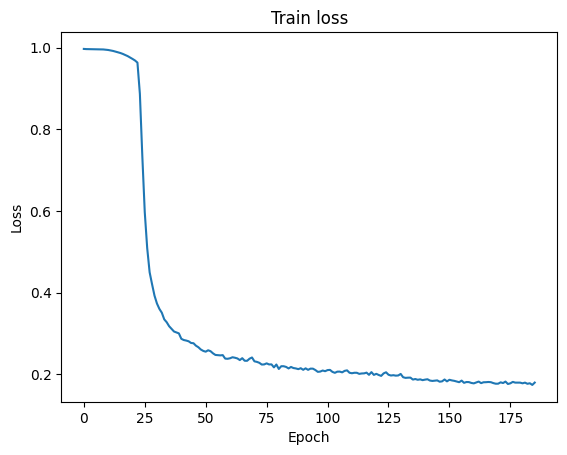

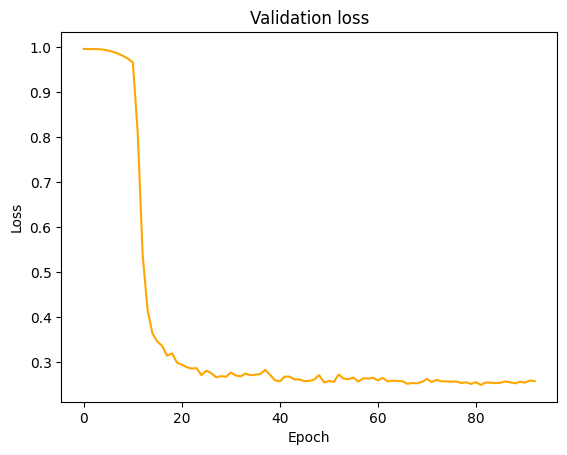

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="train")
plt.title("Train loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig("train_loss.png")
plt.show()
plt.plot(val_losses, label="val", color="orange")
plt.title("Validation loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig("val_loss.png")
plt.show()

In [9]:
filename = "./model-monai-400epoch-3000img-512x512.pth"
torch.save(model.state_dict(), filename)

## Testowanie


In [11]:
import torch
from monai.networks.nets import UNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# filename = "./models/best-model/model-monai-400epoch-3000img-256x256.pth"
filename = "./model/monai-400epoch-3000img-512x512/model_210.pth"

model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

model.load_state_dict(torch.load(filename))

<All keys matched successfully>

Average iou: 0.73
Average dice coefficient: 0.82
Average recall: 0.88
Average precision: 0.80


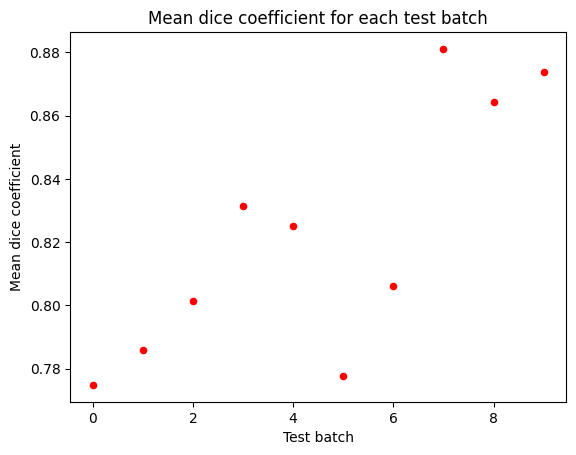

In [12]:
from monai.metrics import compute_iou, compute_dice
import numpy as np

from util import recall, precision

dices = []
ious = []
recalls = []
precisions = []

model.eval()
with torch.no_grad():
    for i, batch_data in enumerate(test_dataloader):
        img, mask = batch_data["img"].to(device), batch_data["mask"].to(device)
        output = torch.sigmoid(model(img))
        torch.where(
            output > 0.5,
            torch.tensor([1.0], device=device),
            torch.tensor([0.0], device=device),
            out=output,
        )
        torch.where(
            mask > 0.0,
            torch.tensor([1.0], device=device),
            torch.tensor([0.0], device=device),
            out=mask,
        )
        dice_coeff = compute_dice(output, mask, ignore_empty=False).mean(dim=0)
        iou = compute_iou(output, mask, ignore_empty=False).mean(dim=0)
        r = recall(mask, output).mean()
        p = precision(mask, output).mean()
        dices.append(dice_coeff.item())
        ious.append(iou.item())
        recalls.append(r.item())
        precisions.append(p.item())
print(f"Average iou: {(sum(ious) / len(ious)):.2f}")
print(f"Average dice coefficient: {(sum(dices) / len(dices)):.2f}")
print(f"Average recall: {(sum(recalls) / len(recalls)):.2f}")
print(f"Average precision: {(sum(precisions) / len(precisions)):.2f}")
plt.scatter(np.arange(len(dices)), dices, s=20, c="red")
plt.xlabel("Test batch")
plt.ylabel("Mean dice coefficient")
plt.title("Mean dice coefficient for each test batch")
plt.savefig("dice_metric.png")